In [1]:
!pip -q install pandas numpy scikit-learn matplotlib



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


**Imports**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor



from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option("display.max_columns", 200)


In [4]:
df = pd.read_csv("data.csv")
print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (722, 21)


,ticker,name,currency,exchange,industry,logo,weburl,environment_grade,environment_level,social_grade,social_level,governance_grade,governance_level,environment_score,social_score,governance_score,total_score,last_processing_date,total_grade,total_level,cik
0,dis,Walt Disney Co,USD,"NEW YORK STOCK EXCHANGE, INC.",Media,https://static.finnhub.io/logo/ef50b4a2b263c84...,https://thewaltdisneycompany.com/,A,High,BB,Medium,BB,Medium,510,316,321,1147,19-04-2022,BBB,High,1744489
1,gm,General Motors Co,USD,"NEW YORK STOCK EXCHANGE, INC.",Automobiles,https://static.finnhub.io/logo/9253db78-80c9-1...,https://www.gm.com/,A,High,BB,Medium,B,Medium,510,303,255,1068,17-04-2022,BBB,High,1467858
2,gww,WW Grainger Inc,USD,"NEW YORK STOCK EXCHANGE, INC.",Trading Companies and Distributors,https://static.finnhub.io/logo/f153dcda-80eb-1...,https://www.grainger.com/,B,Medium,BB,Medium,B,Medium,255,385,240,880,19-04-2022,BB,Medium,277135
3,mhk,Mohawk Industries Inc,USD,"NEW YORK STOCK EXCHANGE, INC.",Consumer products,https://static.finnhub.io/logo/26868a62-80ec-1...,https://mohawkind.com/,A,High,B,Medium,BB,Medium,570,298,303,1171,18-04-2022,BBB,High,851968
4,lyv,Live Nation Entertainment Inc,USD,"NEW YORK STOCK EXCHANGE, INC.",Media,https://static.finnhub.io/logo/1cd144d2-80ec-1...,https://www.livenationentertainment.com/,BBB,High,BB,Medium,B,Medium,492,310,250,1052,18-04-2022,BBB,High,1335258


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 722 entries, 0 to 721
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ticker                722 non-null    object
 1   name                  722 non-null    object
 2   currency              722 non-null    object
 3   exchange              722 non-null    object
 4   industry              709 non-null    object
 5   logo                  702 non-null    object
 6   weburl                706 non-null    object
 7   environment_grade     722 non-null    object
 8   environment_level     722 non-null    object
 9   social_grade          722 non-null    object
 10  social_level          722 non-null    object
 11  governance_grade      722 non-null    object
 12  governance_level      722 non-null    object
 13  environment_score     722 non-null    int64 
 14  social_score          722 non-null    int64 
 15  governance_score      722 non-null    in

In [6]:
df.isna().sum().sort_values(ascending=False)


logo                    20
weburl                  16
industry                13
ticker                   0
governance_level         0
total_level              0
total_grade              0
last_processing_date     0
total_score              0
governance_score         0
social_score             0
environment_score        0
social_level             0
governance_grade         0
name                     0
social_grade             0
environment_level        0
environment_grade        0
exchange                 0
currency                 0
cik                      0
dtype: int64

**Define ESG features**

In [7]:
df = df.drop_duplicates()

num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

print("Cleaned Shape:", df.shape)


Cleaned Shape: (722, 21)


In [8]:
environmental_features = ["environment_score"]
social_features = ["social_score"]
governance_features = ["governance_score"]

all_features = environmental_features + social_features + governance_features



**Normalize ESG features**

In [9]:
missing_cols = [c for c in all_features if c not in df.columns]

if missing_cols:
    print("Missing columns:", missing_cols)
else:
    print("All ESG feature columns found ✔")



All ESG feature columns found ✔


In [10]:
scaler = MinMaxScaler()
df[all_features] = scaler.fit_transform(df[all_features])

df[all_features].head()


,environment_score,social_score,governance_score
0,0.597303,0.307692,0.6150
1,0.597303,0.282051,0.4500
2,0.105973,0.443787,0.4125
3,0.712909,0.272189,0.5700
4,0.562620,0.295858,0.4375


In [11]:
df["E_score"] = df[environmental_features].mean(axis=1)
df["S_score"] = df[social_features].mean(axis=1)
df["G_score"] = df[governance_features].mean(axis=1)

df[["E_score", "S_score", "G_score"]].head()


,E_score,S_score,G_score
0,0.597303,0.307692,0.6150
1,0.597303,0.282051,0.4500
2,0.105973,0.443787,0.4125
3,0.712909,0.272189,0.5700
4,0.562620,0.295858,0.4375


In [12]:
def calculate_esg_score(E, S, G, wE=0.4, wS=0.3, wG=0.3):
    return (E * wE) + (S * wS) + (G * wG)

df["ESG_score"] = calculate_esg_score(
    df["E_score"], df["S_score"], df["G_score"]
)

df[["E_score", "S_score", "G_score", "ESG_score"]].head()


,E_score,S_score,G_score,ESG_score
0,0.597303,0.307692,0.6150,0.515729
1,0.597303,0.282051,0.4500,0.458536
2,0.105973,0.443787,0.4125,0.299275
3,0.712909,0.272189,0.5700,0.537821
4,0.562620,0.295858,0.4375,0.445056


**ESG score distribution**

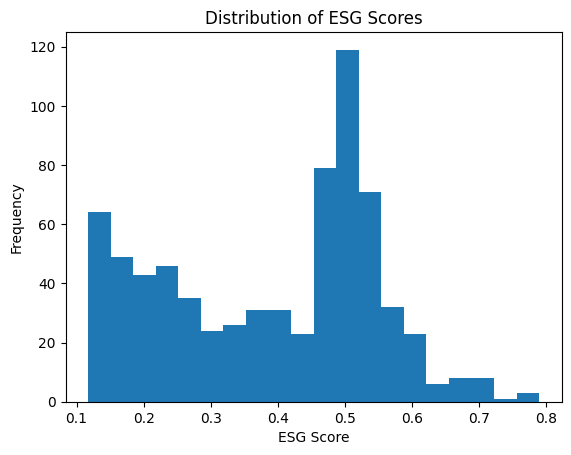

In [13]:
plt.figure()
plt.hist(df["ESG_score"], bins=20)
plt.xlabel("ESG Score")
plt.ylabel("Frequency")
plt.title("Distribution of ESG Scores")
plt.show()


In [14]:
company_col = "company"  # change if needed

if company_col in df.columns:
    df.sort_values("ESG_score", ascending=False)[
        [company_col, "ESG_score"]
    ].head(10)
else:
    df.sort_values("ESG_score", ascending=False)[["ESG_score"]].head(10)


In [15]:
target_col = "target_esg_score"  # change if available

if target_col in df.columns:
    y_true = df[target_col]
    y_pred = df["ESG_score"]

    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("R²:", r2_score(y_true, y_pred))
else:
    print("No target ESG score available — evaluation skipped.")


No target ESG score available — evaluation skipped.


In [16]:
if "total_score" in df.columns:
    df[["ESG_score", "total_score"]].describe()
else:
    print("Column 'total_score' not found in dataset.")


**Scatter plot: ESG_score vs total_score**

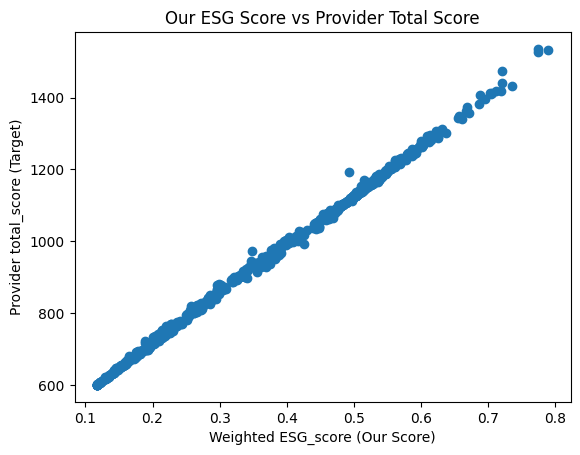

In [17]:
if "total_score" in df.columns:
    plt.figure()
    plt.scatter(df["ESG_score"], df["total_score"])
    plt.xlabel("Weighted ESG_score (Our Score)")
    plt.ylabel("Provider total_score (Target)")
    plt.title("Our ESG Score vs Provider Total Score")
    plt.show()
else:
    print("Column 'total_score' not found.")


In [18]:
target_col = "total_score"
if target_col not in df.columns:
    raise KeyError("Target column 'total_score' not found. Cannot train ML model.")


In [19]:
X = df[all_features]
y = df[target_col]

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (722, 3)
y shape: (722,)


**Train-test split**

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])


Train size: 577
Test size: 145


**Train Linear Regression**

In [21]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

print("Linear Regression trained ✔")


Linear Regression trained ✔


In [22]:
y_pred_lr = lr_model.predict(X_test)
y_pred_lr[:10]


array([1063., 1086., 1192.,  803., 1133., 1130.,  818., 1161., 1255.,
        715.])

In [23]:
mae = mean_absolute_error(y_test, y_pred_lr)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2 = r2_score(y_test, y_pred_lr)

print("Linear Regression Results")
print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)


Linear Regression Results
MAE : 5.801948959585922e-14
RMSE: 8.65298255925367e-14
R²  : 1.0


In [24]:
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lr_model.coef_
}).sort_values(by="Coefficient", ascending=False)

coef_df


,Feature,Coefficient
0,environment_score,519.0
1,social_score,507.0
2,governance_score,400.0


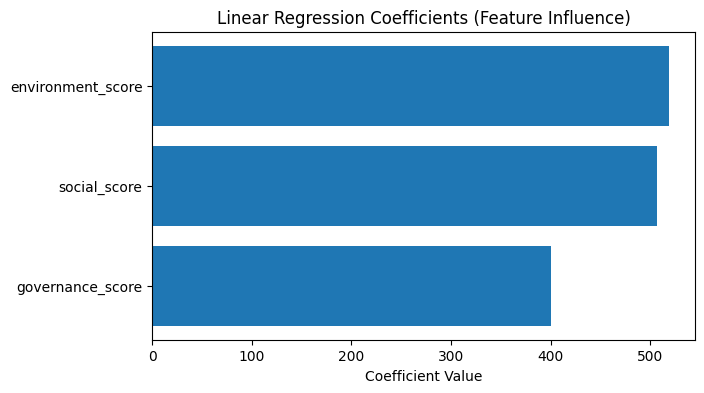

In [25]:
plt.figure(figsize=(7,4))
plt.barh(coef_df["Feature"], coef_df["Coefficient"])
plt.xlabel("Coefficient Value")
plt.title("Linear Regression Coefficients (Feature Influence)")
plt.gca().invert_yaxis()
plt.show()


**Train Random Forest Model**

In [26]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

rf_model.fit(X_train, y_train)
print("Random Forest model trained ✔")


Random Forest model trained ✔


In [27]:
y_pred_rf = rf_model.predict(X_test)


In [28]:
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)

print("Random Forest Results")
print("MAE :", rf_mae)
print("RMSE:", rf_rmse)
print("R²  :", rf_r2)


Random Forest Results
MAE : 8.281586206896554
RMSE: 13.855512957315755
R²  : 0.9956701926760466


In [29]:
rf_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

rf_importance


,Feature,Importance
0,environment_score,0.873860
1,social_score,0.090745
2,governance_score,0.035395


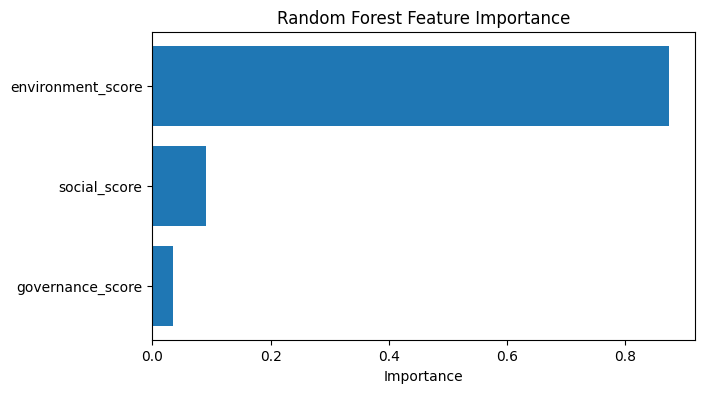

In [30]:
plt.figure(figsize=(7,4))
plt.barh(rf_importance["Feature"], rf_importance["Importance"])
plt.xlabel("Importance")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.show()


In [31]:
comparison_df = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "MAE": [mae, rf_mae],
    "RMSE": [rmse, rf_rmse],
    "R2_Score": [r2, rf_r2]
})

comparison_df


,Model,MAE,RMSE,R2_Score
0,Linear Regression,5.801949e-14,8.652983e-14,1.00000
1,Random Forest,8.281586e+00,1.385551e+01,0.99567


**Save & download output**

In [33]:
output_file = "esg_scored_output_file.csv"
df.to_csv(output_file, index=False)
print("Saved successfully as:", output_file)



Saved successfully as: esg_scored_output_file.csv


In [45]:
# ---- FUNCTION ----
def get_company_esg(company_name):
    result = df[df['name'].str.contains(company_name, case=False, na=False)]
    
    if result.empty:
        print("❌ Company not found")
        return
    
    display(result[['name',
                    'environment_score',
                    'social_score',
                    'governance_score',
                    'total_score',
                    'total_grade']])

# ---- FUNCTION CALL ----
get_company_esg("Tesla")   # Change company name if needed


,name,environment_score,social_score,governance_score,total_score,total_grade
212,Tesla Inc,0.684008,0.0,0.5075,993,BBB


In [36]:
def top_esg_companies(n=10):
    return df.sort_values(by='total_score', ascending=False).head(n)[
        ['name','industry','total_score','total_grade']
    ]
top_esg_companies(10)


,name,industry,total_score,total_grade
452,Conocophillips,Energy,1536,A
176,Microsoft Corp,Technology,1533,A
302,Edison International,Utilities,1528,A
18,Airbnb Inc,Hotels Restaurants and Leisure,1475,A
250,Air Products and Chemicals Inc,Chemicals,1442,A
137,Amazon.com Inc,Retail,1433,A
487,Newmont Corporation,Metals and Mining,1419,A
195,PepsiCo Inc,Beverages,1417,A
494,Exelon Corp,Utilities,1413,A
372,Pioneer Natural Resources Co,Energy,1412,A


In [38]:
def low_esg_companies(n=10):
    return df.sort_values(by='total_score', ascending=True).head(n)[
        ['name','industry','total_score','total_grade']
    ]
low_esg_companies(10)

,name,industry,total_score,total_grade
655,Polar Power Inc,Electrical Equipment,600,B
704,Granite Construction Inc,Construction,600,B
228,Zions Bancorporation NA,Banking,600,B
76,AF Acquisition Corp,NaN,600,B
303,Corning Inc,Electrical Equipment,600,B
395,TE Connectivity Ltd,Electrical Equipment,600,B
396,Teleflex Inc,Health Care,600,B
595,XL Fleet Corp,Auto Components,600,B
72,Allied Esports Entertainment Inc,Hotels Restaurants and Leisure,600,B
313,Coca-Cola Co,Beverages,601,B


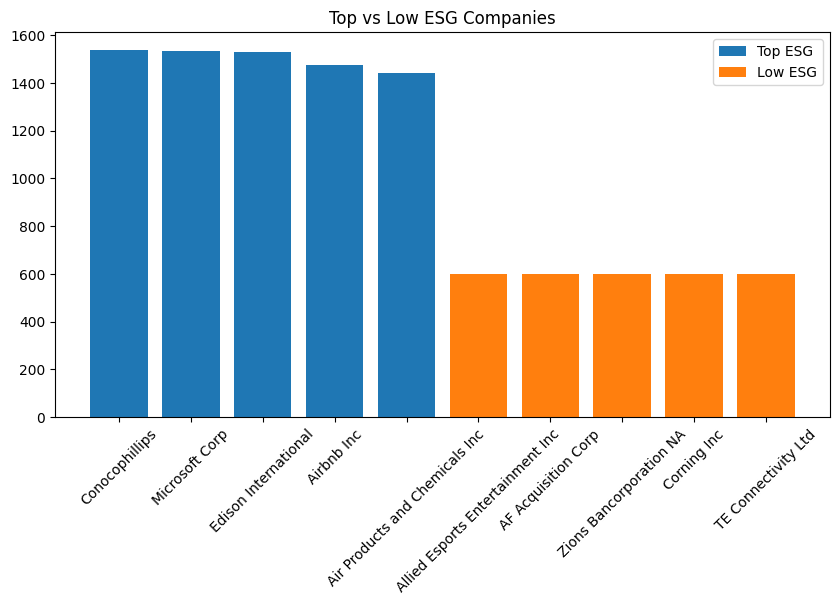

In [50]:
import matplotlib.pyplot as plt

top5 = df.nlargest(5, 'total_score')
low5 = df.nsmallest(5, 'total_score')

plt.figure(figsize=(10,5))
plt.bar(top5['name'], top5['total_score'], label='Top ESG')
plt.bar(low5['name'], low5['total_score'], label='Low ESG')
plt.xticks(rotation=45)
plt.legend()
plt.title("Top vs Low ESG Companies")
plt.show()


In [46]:
def risk_label(score):
    if score >= 75:
        return "Low Risk 🟢"
    elif score >= 50:
        return "Medium Risk 🟡"
    else:
        return "High Risk 🔴"

df['ESG_Risk_Level'] = df['total_score'].apply(risk_label)

# SHOW SAMPLE OUTPUT
df[['name','total_score','ESG_Risk_Level']].head(10)


,name,total_score,ESG_Risk_Level
0,Walt Disney Co,1147,Low Risk 🟢
1,General Motors Co,1068,Low Risk 🟢
2,WW Grainger Inc,880,Low Risk 🟢
3,Mohawk Industries Inc,1171,Low Risk 🟢
4,Live Nation Entertainment Inc,1052,Low Risk 🟢
5,Las Vegas Sands Corp,1178,Low Risk 🟢
6,Clorox Co,1255,Low Risk 🟢
7,ATA Creativity Global,608,Low Risk 🟢
8,American Airlines Group Inc,746,Low Risk 🟢
9,Atlantic American Corp,741,Low Risk 🟢


In [47]:
def peer_compare(company):
    row = df[df['name'].str.contains(company, case=False, na=False)]
    
    if row.empty:
        print("❌ Company not found")
        return
    
    row = row.iloc[0]
    industry_avg = df[df['industry'] == row['industry']]['total_score'].mean()
    
    print("Company:", row['name'])
    print("Industry:", row['industry'])
    print("Company ESG Score:", round(row['total_score'],2))
    print("Industry Average ESG:", round(industry_avg,2))
    print("Above Industry Average:", row['total_score'] > industry_avg)

# ---- FUNCTION CALL ----
peer_compare("Tesla")



Company: Tesla Inc
Industry: Automobiles
Company ESG Score: 993
Industry Average ESG: 859.25
Above Industry Average: True


In [48]:
def explain_esg(company):
    row = df[df['name'].str.contains(company, case=False, na=False)]
    
    if row.empty:
        print("❌ Company not found")
        return
    
    row = row.iloc[0]
    reasons = []
    
    if row['environment_score'] < 50:
        reasons.append("Low environmental performance")
    if row['social_score'] < 50:
        reasons.append("Weak social responsibility indicators")
    if row['governance_score'] < 50:
        reasons.append("Governance risks detected")
    
    print("Company:", row['name'])
    print("Explanation:", ", ".join(reasons) if reasons else "Strong ESG performance")

# ---- FUNCTION CALL ----
explain_esg("Tesla")


Company: Tesla Inc
Explanation: Low environmental performance, Weak social responsibility indicators, Governance risks detected
